# Heart Disease UCI
[Kaggle page for this problem](https://www.kaggle.com/ronitf/heart-disease-uci)

[UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Heart+Disease)

*Amir Hossein Binesh*, Amir Kabir University of Tehran

---

## Part 0 : Import libraries, set constants

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle #to shuffle data before breaking it into test and train
from sklearn.preprocessing import StandardScaler # to scale data (normalize)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
import matplotlib.ticker as ticker
import math
%matplotlib inline

In [2]:
#SETTINGS

TRAIN_FRACTION = .8
NEIGHBOURS = 12

----

## Part 1 : Read and describe the data

**Reading the data**

In [3]:
heart_df = pd.read_csv('heart.csv')
heart_df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


**Describing the data**

First, count number of dataset and its features, then print out its features

In [4]:
n = len(heart_df.index)
m = len(heart_df.columns)
n, m

(303, 14)

In [5]:
for col in heart_df.columns: 
    print(col) 

age
sex
cp
trestbps
chol
fbs
restecg
thalach
exang
oldpeak
slope
ca
thal
target


1. age
2. sex
3. chest pain type (4 values)
4. resting blood pressure
5. serum cholestoral in mg/dl
6. fasting blood sugar > 120 mg/dl
7. resting electrocardiographic results (values 0,1,2)
8. maximum heart rate achieved
9. exercise induced angina
10. oldpeak = ST depression induced by exercise relative to rest
11. the slope of the peak exercise ST segment
12. number of major vessels (0-3) colored by flourosopy
13. thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
14. target(has heart disease): 1 = True, 0 = Flase

---

## Part 2: Analyze and Preprocess

**Analyzing and Visualing the data**

Before going on, let's check if the dataset is balanced or not. Because it can reduce the performance of the classification.

In [6]:
target_counts = heart_df['target'].value_counts()

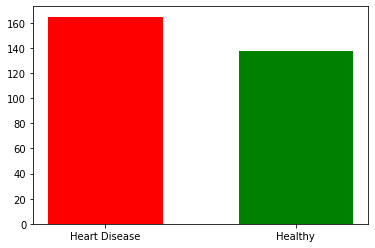

In [7]:
labels = ['Heart Disease', 'Healthy']
colors = ['red', 'green']

plt.bar([0, 1], target_counts, width=0.6, align='center', tick_label=labels, color = colors)

plt.show()

Using correlation matrix, correlated features can be visualized. Also correlation with the target attribute can imply the features we should focus on later.

In [8]:
correlation_matrix = heart_df.corr(method ='kendall')
# Only the absolute value is important
correlation_matrix = correlation_matrix.apply('abs')
correlation_matrix
plt.rcParams["figure.figsize"] = [8,8]

Visualize the correlation matrix using matrix plot.

Using threshold .2, will clean out the matrix plot from correlations between -.2 and .2 which are very close to no correlation.

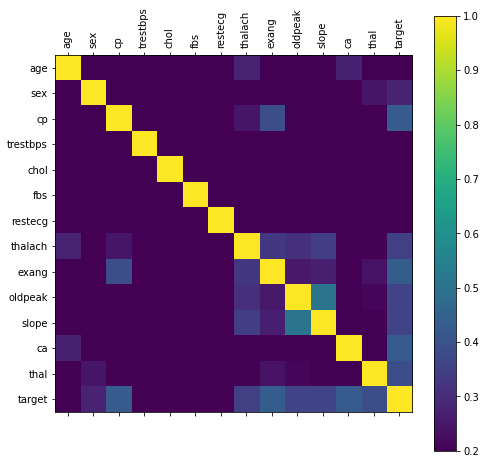

In [9]:
alpha = list(correlation_matrix.columns)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlation_matrix, vmin=.2, vmax=1)
fig.colorbar(cax)

ax.set_xticklabels([''] + alpha)
ax.set_yticklabels([''] + alpha)
plt.xticks(rotation=90)


ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
plt.show()

Now using this matrix plot, let's compare some features with target attribute. We will use cp, ca and exang.

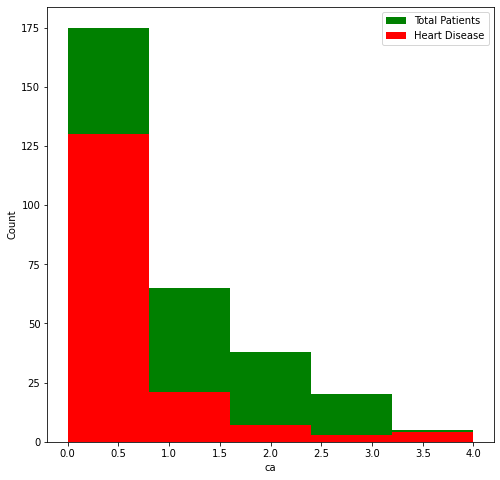

In [10]:
def compare(df, target, feature, bin_count):
    bin_range = (df[feature].min(), df[feature].max())
    dead_df = df[df[target] == 1]
    alive_df = df
    plt.hist(alive_df[feature].values, histtype='bar', bins=bin_count, color = "green", range = bin_range)
    plt.hist(dead_df[feature].values, histtype='bar', bins=bin_count, color = "red", range = bin_range)

    plt.ylabel('Count')
    plt.xlabel(feature)

    plt.legend(('Total Patients', 'Heart Disease'))

    plt.show()
    
compare(heart_df, 'target', 'ca', 5)

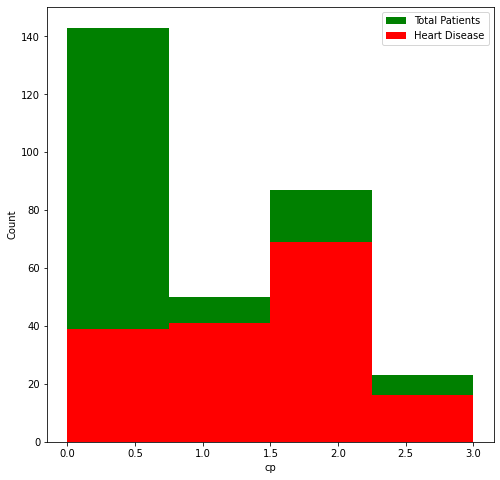

In [11]:
compare(heart_df, 'target', 'cp', 4)

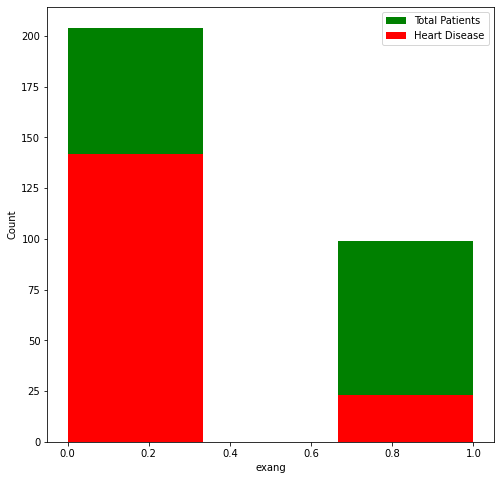

In [12]:
compare(heart_df, 'target', 'exang', 3)

Because I'm curious to see where I am here, let's see how sex and age affect heart disease.

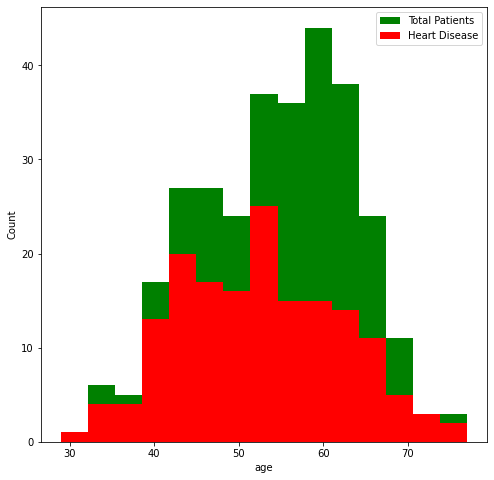

In [13]:
compare(heart_df, 'target', 'age', 15)

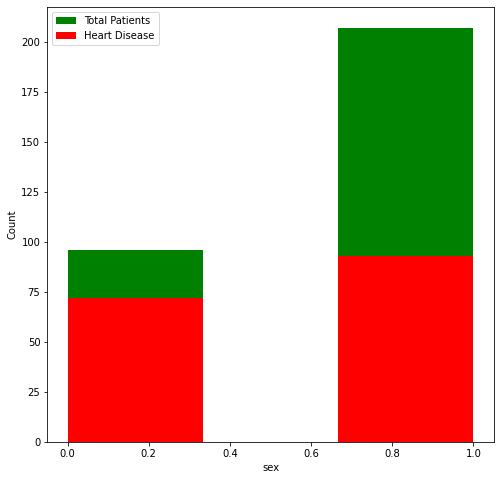

In [14]:
compare(heart_df, 'target', 'sex', 3)

**Preprocessing the data**

Null check

In [15]:
heart_df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

There is no null data, so we are ready to go, but since kNN is sensitive to how the data is distributed in space, we need to do a normalization first.

In [16]:
X = heart_df.drop(['target'], axis = 1)
y = heart_df['target']

sc = StandardScaler()
X = pd.DataFrame(sc.fit_transform(X),columns = X.columns)
scaled_df = pd.concat([X, y], axis = 1)
scaled_df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,0.952197,0.681005,1.973123,0.763956,-0.256334,2.394438,-1.005832,0.015443,-0.696631,1.087338,-2.274579,-0.714429,-2.148873,1
1,-1.915313,0.681005,1.002577,-0.092738,0.072199,-0.417635,0.898962,1.633471,-0.696631,2.122573,-2.274579,-0.714429,-0.512922,1
2,-1.474158,-1.468418,0.032031,-0.092738,-0.816773,-0.417635,-1.005832,0.977514,-0.696631,0.310912,0.976352,-0.714429,-0.512922,1
3,0.180175,0.681005,0.032031,-0.663867,-0.198357,-0.417635,0.898962,1.239897,-0.696631,-0.206705,0.976352,-0.714429,-0.512922,1
4,0.290464,-1.468418,-0.938515,-0.663867,2.082050,-0.417635,0.898962,0.583939,1.435481,-0.379244,0.976352,-0.714429,-0.512922,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,0.290464,-1.468418,-0.938515,0.478391,-0.101730,-0.417635,0.898962,-1.165281,1.435481,-0.724323,-0.649113,-0.714429,1.123029,0
299,-1.033002,0.681005,1.973123,-1.234996,0.342756,-0.417635,0.898962,-0.771706,-0.696631,0.138373,-0.649113,-0.714429,1.123029,0
300,1.503641,0.681005,-0.938515,0.706843,-1.029353,2.394438,0.898962,-0.378132,-0.696631,2.036303,-0.649113,1.244593,1.123029,0
301,0.290464,0.681005,-0.938515,-0.092738,-2.227533,-0.417635,0.898962,-1.515125,1.435481,0.138373,-0.649113,0.265082,1.123029,0


In [17]:
train_size = math.ceil(n * TRAIN_FRACTION)
test_size = n - train_size
train_size, test_size

(243, 60)

In [18]:
# Seprate train and test set
shuffled_df = shuffle(scaled_df)
train_set = shuffled_df.head(int(train_size))
test_set = shuffled_df.tail(int(test_size))
train_set.shape, test_set.shape

((243, 14), (60, 14))

In [19]:
heart_df['target'].value_counts(normalize=True)

1    0.544554
0    0.455446
Name: target, dtype: float64

In [20]:
train_set['target'].value_counts(normalize=True)

1    0.54321
0    0.45679
Name: target, dtype: float64

In [21]:
X_train = train_set.drop(['target'], axis = 1)
y_train = train_set['target']

X_test = test_set.drop(['target'], axis = 1)
y_test = test_set['target']

----

## Part 3 : Classification

### kNN

**Train**

In [22]:
neigh = KNeighborsClassifier(n_neighbors=NEIGHBOURS)
neigh.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=12, p=2,
                     weights='uniform')

In [23]:
knn_train_acc = accuracy_score(y_train, neigh.predict(X_train))
knn_train_acc

0.8600823045267489

**Test**

In [24]:
knn_test_acc = accuracy_score(y_test, neigh.predict(X_test))
knn_test_acc

0.8833333333333333

**Compare k values**

In [25]:
def compareKnn(k_start, k_end, step = 1):
    plt.rcParams["figure.figsize"] = [8,8]
    k = []
    train_results = []
    test_results = []
    for i in range(k_start, k_end + 1, step):
        neigh = KNeighborsClassifier(n_neighbors=i)
        neigh.fit(X_train, y_train)
        
        train_acc = accuracy_score(y_train, neigh.predict(X_train))
        train_results.append(train_acc)
        
        test_acc = accuracy_score(y_test, neigh.predict(X_test))
        test_results.append(test_acc)
        
        k.append(i)
    
    return train_results, test_results, k
        
train_results, test_results, k = compareKnn(1, 20)

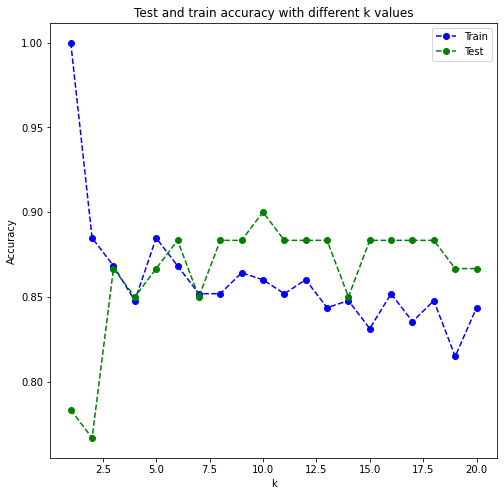

In [26]:
plt.plot(k, train_results, linestyle='--', marker='o', color='b')
plt.plot(k, test_results, linestyle='--', marker='o', color='g')

plt.legend(('Train', 'Test'))
plt.title("Test and train accuracy with different k values")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.show()

### Naive Bayes

**Train**

In [27]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [28]:
nb_train_acc = accuracy_score(y_train, gnb.predict(X_train))
nb_train_acc

0.831275720164609

**Test**

In [29]:
nb_test_acc = accuracy_score(y_test, gnb.predict(X_test))
nb_test_acc

0.9

### Compare Results

In [30]:
data = [[knn_train_acc, knn_test_acc], [nb_train_acc, nb_test_acc]]
pd.DataFrame(data, ['kNN', 'Naive Bayes'], ['Train', 'Test'])

,Train,Test
kNN,0.860082,0.883333
Naive Bayes,0.831276,0.900000
